### Importing Necessary Packages

In [1]:
import numpy as np
import cv2
import pathlib
import PIL.Image as Image
import os
import pandas as pd
import seaborn as sns
from pathlib import Path
import splitfolders
from distutils.dir_util import copy_tree
from glob import glob
import shutil

import matplotlib.pylab as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow_hub as hub


from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(tf.__version__)

2.5.0


### Downloading Flowers Images Dataset

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

### Copying Flowers dataset to its own VGG 6 folder

In [4]:
VGG_19 = 'VGG19 Data'
if os.path.exists(VGG_19):
    shutil.rmtree(VGG_19)
Path(VGG_19).mkdir(parents=True, exist_ok=True)
flower_photos_folder_path = "datasets"
flower_photos_folder_path
copy_tree(flower_photos_folder_path, VGG_19)

['VGG19\\flower_photos\\daisy\\100080576_f52e8ee070_n.jpg',
 'VGG19\\flower_photos\\daisy\\10140303196_b88d3d6cec.jpg',
 'VGG19\\flower_photos\\daisy\\10172379554_b296050f82_n.jpg',
 'VGG19\\flower_photos\\daisy\\10172567486_2748826a8b.jpg',
 'VGG19\\flower_photos\\daisy\\10172636503_21bededa75_n.jpg',
 'VGG19\\flower_photos\\daisy\\102841525_bd6628ae3c.jpg',
 'VGG19\\flower_photos\\daisy\\1031799732_e7f4008c03.jpg',
 'VGG19\\flower_photos\\daisy\\10391248763_1d16681106_n.jpg',
 'VGG19\\flower_photos\\daisy\\10437754174_22ec990b77_m.jpg',
 'VGG19\\flower_photos\\daisy\\10437770546_8bb6f7bdd3_m.jpg',
 'VGG19\\flower_photos\\daisy\\10437929963_bc13eebe0c.jpg',
 'VGG19\\flower_photos\\daisy\\10466290366_cc72e33532.jpg',
 'VGG19\\flower_photos\\daisy\\10466558316_a7198b87e2.jpg',
 'VGG19\\flower_photos\\daisy\\10555749515_13a12a026e.jpg',
 'VGG19\\flower_photos\\daisy\\10555815624_dc211569b0.jpg',
 'VGG19\\flower_photos\\daisy\\10555826524_423eb8bf71_n.jpg',
 'VGG19\\flower_photos\\daisy\\

### Splitting the dataset folders into train and test

In [5]:
input_dir = VGG_19 + '/flower_photos'
output_dir = VGG_19 + '/datasets'

def split_data(input_dir, output_dir, x):
    splitfolders.ratio(input_dir, output = output_dir, seed = 1337, ratio = (x,1-x), group_prefix = None)

split_data(input_dir,output_dir,0.8)
os.rename(output_dir +'/val', output_dir +'/test')

Copying files: 3670 files [00:12, 299.53 files/s]


### Using VGG19 Transfer Learning Algorithm

In [6]:
IMAGE_SIZE = [224, 224]

train_path = output_dir + '/train'
test_path = output_dir + '/test'
print(train_path)
print(test_path)

VGG19/datasets/train
VGG19/datasets/test


##### Importing VGG 16 Library

In [7]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 8s 0us/step


##### Keeping existing weights untrained

In [8]:
for layer in vgg19.layers:
    layer.trainable = False

##### Image folders to be trained on

In [9]:
folders = glob( train_path +'/*')
folders

['VGG19/datasets/train\\daisy',
 'VGG19/datasets/train\\dandelion',
 'VGG19/datasets/train\\roses',
 'VGG19/datasets/train\\sunflowers',
 'VGG19/datasets/train\\tulips']

In [10]:
len(folders)

5

##### Flatenning for the fully connected layer

In [11]:
# our layers - you can add more if you want
x = Flatten()(vgg19.output)

##### Training the final layer for prediction

In [12]:
prediction = Dense(len(folders), activation='softmax')(x)


### Creating VGG19 Model

In [13]:
model = Model(inputs=vgg19.input, outputs=prediction)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##### Compiling the model with loss function, optimizer type and metrics of classification

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


##### Augmenting the training dataset

In [16]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 seed = 42)

Found 2934 images belonging to 5 classes.


In [18]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            seed = 42)

Found 736 images belonging to 5 classes.


##### Fitting the model

In [19]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
92/92 [==============================] - 541s 6s/step - loss: 4.9758 - accuracy: 0.5607 - val_loss: 2.7487 - val_accuracy: 0.2976
Epoch 2/5
92/92 [==============================] - 660s 7s/step - loss: 4.8082 - accuracy: 0.6500 - val_loss: 1.3097 - val_accuracy: 0.5367
Epoch 3/5
92/92 [==============================] - 670s 7s/step - loss: 5.0896 - accuracy: 0.6636 - val_loss: 4.6678 - val_accuracy: 0.3465
Epoch 4/5
92/92 [==============================] - 658s 7s/step - loss: 4.9227 - accuracy: 0.7038 - val_loss: 2.0988 - val_accuracy: 0.4334
Epoch 5/5
92/92 [==============================] - 553s 6s/step - loss: 5.2704 - accuracy: 0.7096 - val_loss: 1.5975 - val_accuracy: 0.4878


##### Plot for Loss

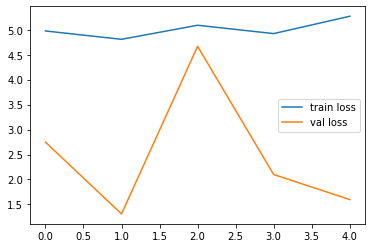

In [20]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()



##### Plot the accuracy

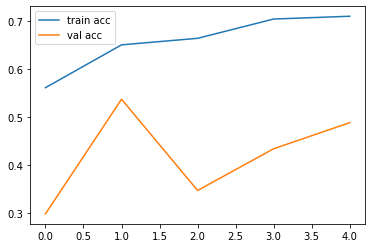

In [21]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

##### Saving the model

In [22]:
model.save('model_vgg19.h5')
